# Deploying stocks model serving

Steps
* [Creating serving graph](#Creating-serving-graph)
* [Testing locally](#Testing-locally)
* [Deploying the serving graph](#Deploying-the-serving-graph)

In [1]:
import mlrun
import os

project = mlrun.get_or_create_project('stocks',user_project=True,context='src/')

> 2022-11-08 08:12:15,472 [info] loaded project stocks from MLRun DB


## Creating serving graph

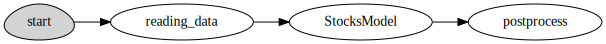

In [6]:
fn = mlrun.code_to_function('serving_stocks', kind='serving',image='mlrun/ml-models', filename='src/serving_stocks.py').apply(mlrun.auto_mount())

graph = fn.set_topology("flow", engine="async")
# Build the serving graph:
graph.to(handler='preprocess', name='reading_data')\
     .to(class_name="StocksModel", model_name='stocks_model', model_path=project.get_artifact_uri('stocks_model'))\
     .to(handler='postprocess',name='postprocess').respond()

fn.set_tracking()

fn.plot(rankdir="LR")

## Testing locally

In [7]:
server = fn.to_mock_server()

> 2022-11-08 08:14:57,282 [info] downloading v3io:///projects/stocks-dani/artifacts/train-stocks-model-handler/0/stocks_model_custom_objects_map.json.json to local temp file
> 2022-11-08 08:14:57,292 [info] downloading v3io:///projects/stocks-dani/artifacts/train-stocks-model-handler/0/stocks_model_custom_objects.zip.zip to local temp file
> 2022-11-08 08:15:05,234 [info] model StocksModel was loaded


In [8]:
import pandas as pd
response = server.test(body={"vector_name": 'stocks',
                             "start_time" : 6, # days to go back
                             "end_time"   : 0,
                             "seq_size"   : 5})

pd.DataFrame(data=response[0], columns=response[1]).head()

writing prediction to kv at /stocks-dani/artifacts/stocks_prediction ...


,prediction,datetime,tickers,true
0,18.639963,2022-11-07 13:50:06,AAL,14.088397
1,318.113692,2022-11-04 16:00:00,ABMD,373.989988
2,98.486260,2022-11-04 16:00:00,ABT,98.070001
3,136.090027,2022-11-07 13:48:58,A,136.820007
4,171.819152,2022-11-07 13:50:01,AAP,181.199996


## Deploying the serving graph

In [ ]:
address = fn.deploy()

In [ ]:
project.set_function(fn,name='serving_stocks')
project.save()

In [ ]:
import json
response = fn.invoke(path=address,
                     body={"vector_name": 'stocks',
                           "start_time" : 6,
                           "end_time"   : 0,
                           "seq_size"   : 5})

pd.DataFrame(data=response[0], columns=response[1])